In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
y_train= np.loadtxt('/kaggle/input/labels/y_train.txt',dtype=float)
y_test= np.loadtxt('/kaggle/input/labels/y_test.txt',dtype=float)


print(y_train.shape)

print(y_test.shape)


(7352,)
(2947,)


In [ ]:
train_dataset_path = '/kaggle/input/img90-train-val-classified/classified_data/train'
validation_dataset_path = '/kaggle/input/img90-train-val-classified/classified_data/validation'

In [ ]:
IMG_WIDTH = 369
IMG_HEIGHT = 369
BATCH_SIZE = 24

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 5146 images belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 2206 images belonging to 6 classes.


# LABELS:
**1 WALKING 2 WALKING_UPSTAIRS 3 WALKING_DOWNSTAIRS 4 SITTING 5 STANDING 6 LAYING**



In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 1
1 : 2
2 : 3
3 : 4
4 : 5
5 : 6


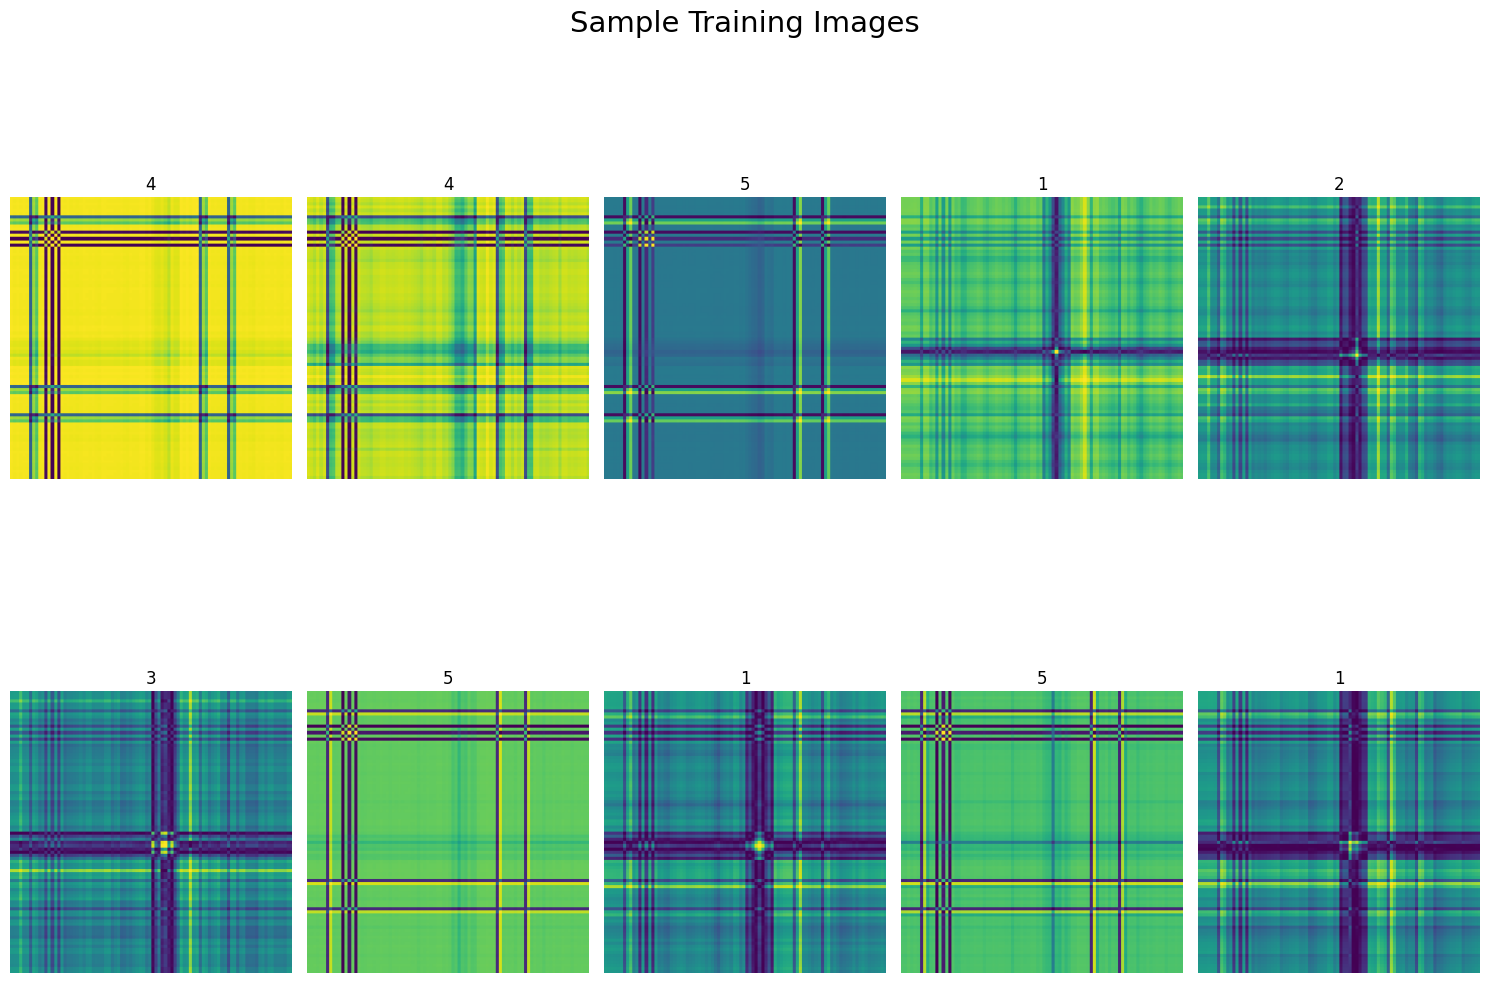

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [ ]:
basemodel =EfficientNetV2B1(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(369, 369, 3)))

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
headmodel = basemodel.output
headmodel = MaxPooling2D(pool_size = (4,4))(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(6, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 369, 369,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 369, 369,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 369, 369,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 185, 185,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 185, 185,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 185, 185,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 185, 185,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 185, 185,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 185, 185,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 185, 185,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 185, 185,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 185, 185,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 185, 185,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 185, 185,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 93, 93,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 93, 93,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 93, 93,    │          0 │ block2a_expand_b

 Total params: 7,272,890 (27.74 MB)

 Trainable params: 7,201,818 (27.47 MB)

 Non-trainable params: 71,072 (277.62 KB)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:
optimizer = Adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=25, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/25


I0000 00:00:1715170853.869697     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715170854.022074     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715171004.128187     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/215 - 327s - 2s/step - accuracy: 0.7293 - loss: 0.7796 - val_accuracy: 0.8345 - val_loss: 0.6604 - learning_rate: 1.0000e-04
Epoch 2/25
215/215 - 61s - 283ms/step - accuracy: 0.8589 - loss: 0.3680 - val_accuracy: 0.8694 - val_loss: 0.4911 - learning_rate: 1.0000e-04
Epoch 3/25
215/215 - 61s - 284ms/step - accuracy: 0.8951 - loss: 0.2720 - val_accuracy: 0.8690 - val_loss: 0.5331 - learning_rate: 1.0000e-04
Epoch 4/25
215/215 - 61s - 283ms/step - accuracy: 0.9199 - loss: 0.2104 - val_accuracy: 0.8776 - val_loss: 0.5709 - learning_rate: 1.0000e-04
Epoch 5/25
215/215 - 61s - 283ms/step - accuracy: 0.9289 - loss: 0.1776 - val_accuracy: 0.8676 - val_loss: 0.5793 - learning_rate: 1.0000e-04
Epoch 6/25
215/215 - 61s - 282ms/step - accuracy: 0.9370 - loss: 0.1616 - val_accuracy: 0.8690 - val_loss: 0.5889 - learning_rate: 1.0000e-04
Epoch 7/25
215/215 - 61s - 282ms/step - accuracy: 0.9518 - loss: 0.1220 - val_accuracy: 0.8713 - val_loss: 0.7292 - learning_rate: 1.0000e-04
Epoch 8/25
215/215 

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
learning_rate = history.history['learning_rate']

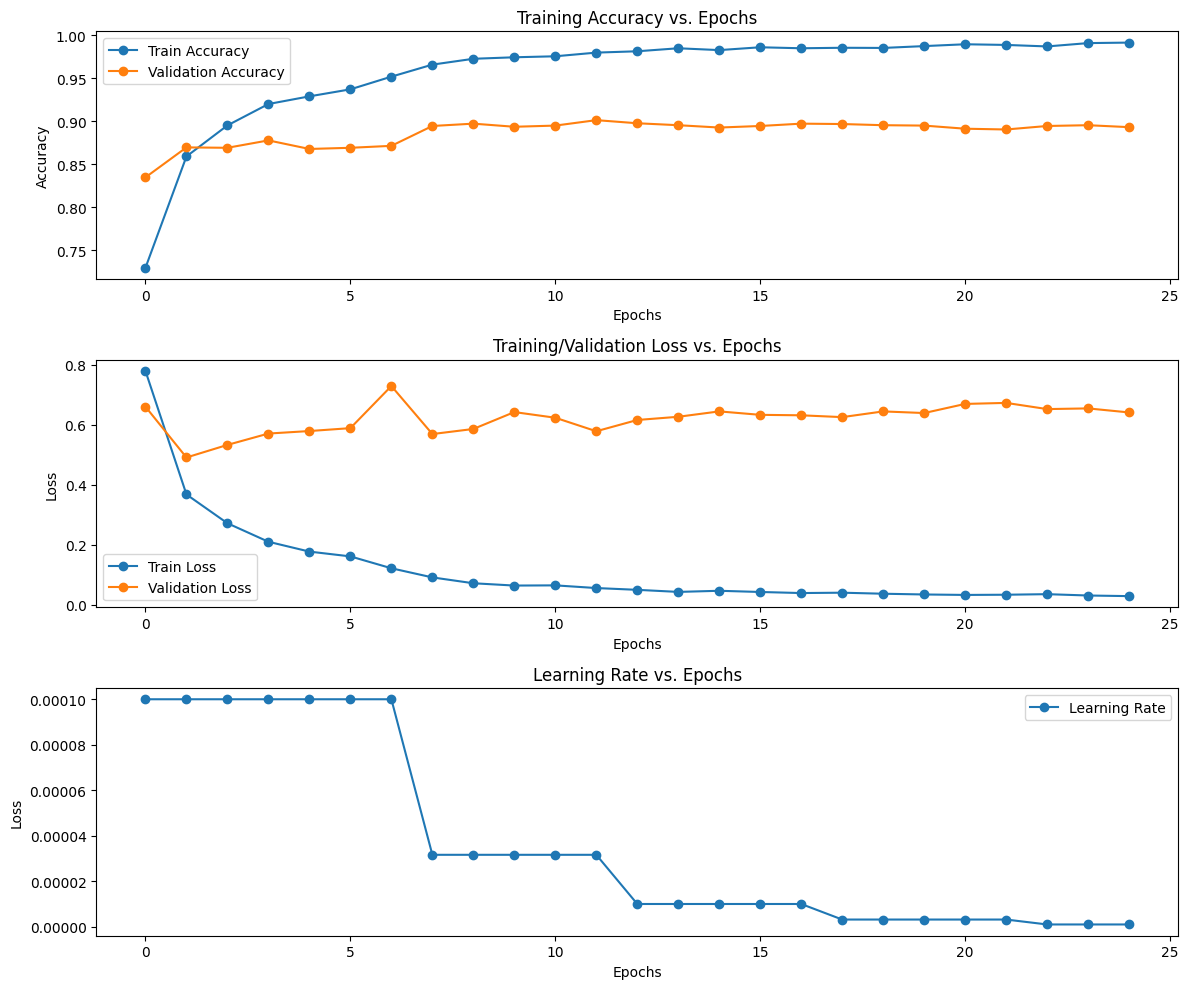

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
import glob
cv_img1 = []
for img in glob.glob("/kaggle/input/img90-train-val-classified/classified_data/train/1/*.png"):
    n= cv2.imread(img)
    cv_img1.append(n)
cv_img2 = []
for img in glob.glob("/kaggle/input/img90-train-val-classified/classified_data/train/2/*.png"):
    n= cv2.imread(img)
    cv_img2.append(n)
cv_img3 = []
for img in glob.glob("/kaggle/input/img90-train-val-classified/classified_data/train/3/*.png"):
    n= cv2.imread(img)
    cv_img3.append(n)
cv_img4 = []
for img in glob.glob("/kaggle/input/img90-train-val-classified/classified_data/train/4/*.png"):
    n= cv2.imread(img)
    cv_img4.append(n)
cv_img5 = []
for img in glob.glob("/kaggle/input/img90-train-val-classified/classified_data/train/5/*.png"):
    n= cv2.imread(img)
    cv_img5.append(n)
cv_img6 = []
for img in glob.glob("/kaggle/input/img90-train-val-classified/classified_data/train/6/*.png"):
    n= cv2.imread(img)
    cv_img6.append(n)

In [ ]:
arr1 = np.array(cv_img1)
arr2 = np.array(cv_img2)
arr3 = np.array(cv_img3)
arr4 = np.array(cv_img4)
arr5 = np.array(cv_img5)
arr6 = np.array(cv_img6)

In [ ]:
print(arr1.shape)
print(arr2.shape)
print(arr3.shape)
print(arr4.shape)
print(arr5.shape)
print(arr6.shape)

(858, 369, 369, 3)
(751, 369, 369, 3)
(690, 369, 369, 3)
(900, 369, 369, 3)
(962, 369, 369, 3)
(985, 369, 369, 3)


In [ ]:
train_data=np.concatenate([arr1,arr2,arr3,arr4,arr5,arr6],axis=0)

In [ ]:
train_data.shape

(5146, 369, 369, 3)

In [ ]:
layer_output = model.get_layer('flatten').output
intermediate_model= Model(inputs=model.input, outputs=layer_output)
feature_extractor_env2b1=intermediate_model.predict(train_data)

161/161 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step


In [ ]:
feature_extractor_env2b1.shape

(5146, 2304)

In [ ]:
Y1= np.full((858, 1), 1)
print(Y1.shape)
print(Y1[0])
Y2= np.full((751, 1), 2)
Y3= np.full((690, 1), 3)
Y4= np.full((900, 1), 4)
Y5= np.full((962, 1), 5)
Y6= np.full((985, 1), 6)

(858, 1)
[1]


In [ ]:
Y=np.concatenate([Y1,Y2,Y3,Y4,Y5,Y6],axis=0)
print(Y.shape)

(5146, 1)
